**Nome:** Tiago Amorim

**RA:** 100.675

Transforme este notebook num relatório técnico de experimentos com uma arquitetura VAE (Variational Autoencoder).

Adicione comentários aos diferentes blocos de código, explicitando o propósito de cada bloco.

Como é construído o espaço latente? Mostre resultados diferentes para diferentes configurações.

Altere parâmetros de treinamento do modelo.

Proponha maneiras de avaliar a qualidade das amostras geradas.

### Attr2Font

* Github: https://github.com/hologerry/Attr2Font
* Dataset: https://drive.google.com/file/d/1TTqAklfsAp6KOPxCVl2jktH8kN4lEmI_/view

### Pacotes

In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets,transforms
from torchvision.utils import save_image, make_grid
from PIL import Image
# from tqdm.notebook import tqdm
from tqdm import tqdm
# from tqdm.auto import tqdm
import os
import shutil
import random
random.seed(5)
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format='svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
# Dataset Attr2font
from datetime import datetime

from torch.utils.tensorboard import SummaryWriter

### Google Drive

In [2]:
## Conexão com o google drive, se achar necessário
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

### Dados:

**Etapas**

1. Organização da base de dados: figuras RGB de números (0-9) e letras (a-z e A-Z) de diferentes tipos de fonte e propriedades (regular, negrito, itálico, ...).
    * São quase 70 mil imagens png de mais de mil categorias diferentes.
    * Pastas originais foram alteradas para se conformar à minha organização.
2. Definição de um _pipeline_ para transformação das imagens.
    * As imagens são reduzidas de 256x256 para 50x50.
    * É feita uma transformação de RGB para escala de cinza.

In [3]:
# Baixando os dados do Attr2font que podem ser encontrados em:
# !gdown --id 1TTqAklfsAp6KOPxCVl2jktH8kN4lEmI_
# !unzip ./_data/explor_all.zip

In [4]:
# Cria os diretórios de interesse:
# !mkdir _data
# !mkdir results
# !mkdir models
# !mv ./explor_all/image ./_data/Fonts
# !rm -rf ./explor_all

In [5]:
def count_folders_and_png_files(folder, msg):
    items = os.listdir(folder)
    folders = [item for item in items if os.path.isdir(os.path.join(folder, item))]
    print(f"{msg} number of subfolders: {len(folders):,}")

    png_count = 0
    for _, _, files in os.walk(folder):
        png_files = [file for file in files if file.lower().endswith('.png')]
        png_count += len(png_files)
    print(f"{msg} number of png files: {png_count:,}")

count_folders_and_png_files('./_data/Fonts', "'Fonts'")

'Fonts' number of subfolders: 1,116
'Fonts' number of png files: 69,192


In [6]:
epochs=5
batch_size=64
torch.manual_seed(17)

In [7]:
def show_img(img, title=None):
    img = img.permute(1, 2, 0)
    if img.shape[2]==1:
        img = img.view(img.shape[0], img.shape[1])
    if title is None:
        plt.title(f'Image has size {img.cpu().numpy().shape}')
    else:
        plt.title(title)
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.show()

In [8]:
path='./_data/Fonts'
train_path = './_data/trainFonts'
val_path = './_data/valFonts'

for f in [path, train_path, val_path]:
    os.makedirs(f, exist_ok=True)

In [9]:
transforms_all = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(size=50),
    transforms.ToTensor()
])

dummy_batch = torch.utils.data.DataLoader(
    datasets.ImageFolder(path,transform=transforms.ToTensor()),
    batch_size=1, shuffle=True
)

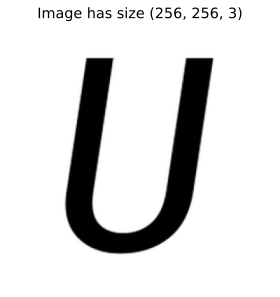

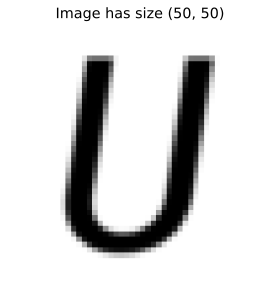

In [10]:
for batch in dummy_batch:
  original_image=batch[0][0]
  show_img(original_image)
  show_img(transforms_all(transforms.ToPILImage()(original_image)))
  break

### Separação em dados de treino e validação

**Etapas**

3. Separa parte dos dados em treinamento e validação.
    * São utilizadas apenas as primeiras 134 variações de fonte.
    * De cada variação, 42 imagens são copiadas para os dados de treino, e 20 imagens para os dados de validação.

In [11]:
folders=os.listdir(path)
count_folders_and_png_files(path, "Original Fonts")

shutil.rmtree(train_path)
shutil.rmtree(val_path)

os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

# Podemos limitar em num_folders a quantidade total de pasta que iremos trabalhar, no total temos 1116.
num_folders = 134
count_folders = 1
for folder in folders:
    if count_folders <= num_folders:
      os.mkdir(f'{train_path}/{folder}')
      os.mkdir(f'{val_path}/{folder}')
      images = os.listdir(f'{path}/{folder}')
      random.shuffle(images)
      for image in images[:20]:
        shutil.copy(f'{path}/{folder}/{image}', f'{val_path}/{folder}/{image}')
      for image in images[20:]:
        shutil.copy(f'{path}/{folder}/{image}', f'{train_path}/{folder}/{image}')
    count_folders += 1

count_folders_and_png_files(train_path, "Train Fonts")
count_folders_and_png_files(val_path, "Val Fonts")

Original Fonts number of subfolders: 1,116
Original Fonts number of png files: 69,192
Train Fonts number of subfolders: 134
Train Fonts number of png files: 5,628
Val Fonts number of subfolders: 134
Val Fonts number of png files: 2,680


In [12]:
print(len(os.listdir(train_path)))
print(len(os.listdir(val_path)))

134
134


### Construção do Dataset e Dataloader

**Etapas**

4. Definição dos _DataLoaders_ de treinamento e validação.
    * Cada _DataLoader_ incorpora a redução de escala e transformação em imagens em escala de cinza.

In [13]:
def get_dataloaders(batch_size=64, size=50):
    transforms_set = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(size=size),
        transforms.ToTensor()
    ])

    train_loader=torch.utils.data.DataLoader(
        datasets.ImageFolder(f'{train_path}',transform=transforms_set),
        batch_size=batch_size, shuffle=True
    )

    val_loader=torch.utils.data.DataLoader(
        datasets.ImageFolder(f'{val_path}',transform=transforms_set),
        batch_size=batch_size, shuffle=True
    )

    return train_loader, val_loader

### Implementação VAE

**Etapas**

5. Definição da arquitetura do VAE
    * São utilizadas camadas densas.
    * Existem 3 elementos principais na arquitetura: **Encoder**, **Reparametrização** e **Decoder**.
    * **Encoder**:
        * Passa dados de entrada achatados (_flatten_) de dimensão 2500 para dimensão 1000. Seguido por ativação ReLU.
        * Passa dados da dimensão 1000 em duas camadas paralelas para a dimensão do espaço latente.
        * Cada dimensão do espaço latente é caracterizada por uma média ($\mu$) e um logarítimico da variância ($log(\sigma^2)$).
    * **Reparametrização**:
        * _Reamostra_ cada elemento do espaço latente em função das respectivas médias e logarítimicos da variância.

        $$
        \sigma = e^{0.5*log(\sigma^2)} \\
        x = \mu + \epsilon \sigma
        $$

        * A variável aleatória $\epsilon$ segue distribuição normal padrão: $\epsilon \sim \mathcal{N}(0, 1)$. 
    * **Decoder**:
        * Passa do espaço latente para a dimensão 1000, seguido de ativação ReLU.
        * Passa da dimensão 1000 de volta para a dimensão do dado original. A ativação sigmóide deixa os valores de saída dentro da faixa de variação do dado original: $[0,1]$.
    * Código original foi adaptado para dar mais flexibilidade de testar alterações na arquitetura.
        

In [14]:
class VAE(nn.Module):
    def __init__(self, input_dim=50*50, z=32, hidden_dim=1000, n_hidden_encoder=1, n_hidden_decoder=1):
        super(VAE, self).__init__()

        assert n_hidden_encoder >= 1, 'Number of hidden layers must be at least 1.'
        assert n_hidden_decoder >= 1, 'Number of hidden layers must be at least 1.'

        self.input_dim = input_dim # Dimensão de entrada
        self.z = z # Dimensão do espaço latente
        self.hidden_dim = hidden_dim # Dimensão da camada escondida
        self.n_hidden_encoder = n_hidden_encoder # Número de camadas escondidas no encoder
        self.n_hidden_decoder = n_hidden_decoder # Número de camadas escondidas no decoder

        #ENCODER
        self.encoder = nn.Sequential()
         # Camada densa do dado de entrada para dimensão hidden_dim (1000)
        self.encoder.add_module('input_linear', nn.Linear(input_dim,hidden_dim))
        self.encoder.add_module('input_act',nn.ReLU())
        # Camadas densas ocultas adicionais
        for i in range(1, n_hidden_encoder):
            self.encoder.add_module(f'{i+1}_linear',nn.Linear(hidden_dim, hidden_dim))
            self.encoder.add_module(f'{i+1}_act',nn.ReLU())
        # Camadas densas de dimensão hidden_dim para espaço latente z: médias e log(vars)
        self.fc21 = nn.Linear(hidden_dim,z)
        self.fc22 = nn.Linear(hidden_dim,z)

        #DECODER
        self.decoder = nn.Sequential()
        # Camada densa do espaço latente z para dimensão hidden_dim
        self.decoder.add_module('input_linear', nn.Linear(z,hidden_dim))
        self.decoder.add_module('input_act',nn.ReLU())
        # Camadas densas ocultas adicionais
        for i in range(1, n_hidden_decoder):
            self.decoder.add_module(f'{i+1}_linear',nn.Linear(hidden_dim, hidden_dim))
            self.decoder.add_module(f'{i+1}_act',nn.ReLU())
        # Camadas densas de dimensão hidden_dim para dimensão de entrada
        self.decoder.add_module('output_linear', nn.Linear(hidden_dim,input_dim))
        self.decoder.add_module('output_act',nn.Sigmoid())

    def encode(self, x):
        h1 = self.encoder(x)
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # don't forget forward pass re-index
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

### Implementação Loss Function

**Etapas**

6. Definição da função de perda.
    * Existem dois termos na função de perda: **Entropia Binária Cruzada** e **Divergente de Kullback-Leibler**.
    * **Entropia Binária Cruzada**:
        * Medida do quando as imagens original e reconstruída se parecem, pixel a pixel.
    * **Divergente de Kullback-Leibler**:
        * Medida do quanto a distribuição do espaço latente se aproxima de uma distribuição normal padrão.
    * Desta forma a otimização dos pesos da rede tem duplo objetivo: reconstruir as imagens de entrada ao mesmo tempo que busca uma representação no espaço latente que siga uma normal padrão.
    * Código original foi alterado para retornar termos da _loss_ separadamente e incluir parâmetro para controlar impacto de cada termo.

In [15]:
def loss_function(recon_x, x, mu, logvar, beta=0.50, input_dim=50*50):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, input_dim), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss = 2.0 * ((1 - beta) * BCE + beta * KLD)
    return loss, BCE.detach(), KLD.detach()

### Criação do Modelo

**Etapas**

6. Cria nova instância do modelo.

In [16]:
def initialize_test_run(options):
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Device: ',device)
    model=VAE(
        input_dim=options['input_dim_flat'],
        z=options['z'],
        hidden_dim=options['hidden_dim'],
        n_hidden_encoder=options['n_hidden_encoder'],
        n_hidden_decoder=options['n_hidden_decoder']).to(device)
    optimizer=optim.Adam(model.parameters(),lr=options['lr'])
    writer = SummaryWriter(f'_runs/{options["model_name"]}')
    return device, model, optimizer, writer

### Loops de Treinamento e Avaliação

**Etapas**

7. Rotina de avaliação:
    * Calcula a _loss_ média do conjunto de validação.
    * Guarda uma amostra comparando a figura original com a reconstruída.
8. Rotina para gerar novas amostras:
    * Guarda 64 amostras geradas a partir de amostragem no espaço latente.
9. Rotina de treino:
    * Treinamento realizado em mini-batches de 64 amostras e otimizador Adam.

In [17]:
def evaluate(epoch, device, model, writer, val_loader, options):

    val_loss = 0
    val_loss_bce = 0
    val_loss_kld = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(val_loader):

            data=data.to(device)
            recon_batch,mu,logvar=model(data)
            loss, loss_bce, loss_kld = loss_function(recon_batch,data,mu,logvar)
            val_loss += loss.item()
            val_loss_bce += loss_bce.item()
            val_loss_kld += loss_kld.item()

            if i == 0 and epoch%50==1:
                n = min(data.size(0), 16)
                comparison = torch.cat([
                    data[:n],
                    recon_batch.view(options['batch_size'], 1,
                                     options['input_dim'][0], options['input_dim'][1])[:n]]).cpu()
                # save_image(comparison.cpu(),
                #            './results/reconstruction_' + str(epoch) + '.png', nrow=n)
                grid = make_grid(comparison, nrow=16, normalize=True, scale_each=True).cpu()
                show_img(grid, title=f'Epoch {epoch}')
                # grid_np = grid.permute(1, 2, 0).cpu().numpy()
                writer.add_images('Img/Reconstruction', grid, epoch, dataformats='CHW')

    val_loss /= len(val_loader.dataset)
    val_loss_bce /= len(val_loader.dataset)
    val_loss_kld /= len(val_loader.dataset)
    return val_loss, val_loss_bce, val_loss_kld


def sample_latent_space(epoch, device, model, writer, options):
    with torch.no_grad():

        # how to sample from our latent space
        sample=torch.randn(64,32).to(device)
        sample=model.decode(sample).cpu()

        # save_image(sample.view(64, 1, 50, 50),
        #            './results/sample_' + str(epoch) + '.png')
        grid = make_grid(sample.view(64, 1, options['input_dim'][0], options['input_dim'][1]), nrow=8, normalize=False, scale_each=False)
        # show_img(sample.view(64, 1, 50, 50), title=f'Epoch {epoch}')
        show_img(grid, title=f'Epoch {epoch}')
        # grid_np = grid.permute(1, 2, 0).numpy()
        writer.add_images('Img/Samples', grid, epoch, dataformats='CHW')

In [18]:
def train(device, model, optimizer, writer, train_loader, val_loader, epoch, options):
    model.train()

    train_loss = 0
    train_loss_bce = 0
    train_loss_kld = 0

    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch:03d}', leave=False, disable=False)
    for data, _ in progress_bar:
        progress_bar.set_description(f'Epoch {epoch:03d}')

        data=data.to(device)
        optimizer.zero_grad()
        recon_batch,mu,logvar=model(data)

        loss, loss_bce, loss_kld = loss_function(
            recon_batch,data,mu,logvar, beta=options['beta'], input_dim=options['input_dim_flat'])
        loss.backward()
        train_loss += loss.item()
        train_loss_bce += loss_bce.item()
        train_loss_kld += loss_kld.item()
        optimizer.step()

        progress_bar.set_postfix({'training_loss': f'{(loss.item() / len(data)):.3f}'})
    progress_bar.close()

    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_loss_bce = train_loss_bce / len(train_loader.dataset)
    avg_train_loss_kld = train_loss_kld / len(train_loader.dataset)
    val_loss, val_loss_bce, val_loss_kld = evaluate(
        epoch, device, model, writer, val_loader, options)

    print(f'Epoch {epoch:03d}: train={avg_train_loss:<8.3f} (BCE={avg_train_loss_bce:<8.3f}, KLD={avg_train_loss_kld:<8.3f}), val: {val_loss:<8.3f}')

    writer.add_scalar('Train_Loss/Total', avg_train_loss, epoch)
    writer.add_scalar('Train_Loss/BCE', avg_train_loss_bce, epoch)
    writer.add_scalar('Train_Loss/KLD', avg_train_loss_kld, epoch)

    writer.add_scalar('Val_Loss/Total', val_loss, epoch)
    writer.add_scalar('Val_Loss/BCE', val_loss_bce, epoch)
    writer.add_scalar('Val_Loss/KLD', val_loss_kld, epoch)

    if epoch%100==1:
        torch.save(model.state_dict(), f'./_models/{options['model_name']}_{epoch}.model')

### Treinamento

In [19]:
def make_run(options):
    print(options['model_name'])

    options['input_dim_flat'] = options['input_dim'][0] * options['input_dim'][1]
    device, model, optimizer, writer = initialize_test_run(options)
    train_loader, val_loader = get_dataloaders(options['batch_size'])
    writer.add_hparams(options)

    epochs = options['epochs']
    for epoch in range(1,epochs+1):
        train(device, model, optimizer, writer, train_loader, val_loader, epoch, options)
        if epoch%50==1:
            sample_latent_space(epoch, device, model, writer, options)

    writer.flush()
    writer.close()

In [ ]:
model_name = f'vae_{datetime.now().strftime("%Y%m%d-%H%M%S")}'
options = {
    'model_name': model_name,
    'input_dim': (50, 50),
    'z': 32,
    'hidden_dim': 1000,
    'n_hidden_encoder': 1,
    'n_hidden_decoder': 1,
    'lr': 1e-3,
    'beta': 0.80,
    'epochs': 500,
    'batch_size': 64
}

make_run(options)